In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetic-retinopathyaugemented-image15k-images/kaggle/input/project-phase-1/__results__.html
/kaggle/input/diabetic-retinopathyaugemented-image15k-images/kaggle/input/project-phase-1/__huggingface_repos__.json
/kaggle/input/diabetic-retinopathyaugemented-image15k-images/kaggle/input/project-phase-1/__notebook__.ipynb
/kaggle/input/diabetic-retinopathyaugemented-image15k-images/kaggle/input/project-phase-1/__output__.json
/kaggle/input/diabetic-retinopathyaugemented-image15k-images/kaggle/input/project-phase-1/custom.css
/kaggle/input/diabetic-retinopathyaugemented-image15k-images/kaggle/input/project-phase-1/__results___files/__results___20_0.png
/kaggle/input/diabetic-retinopathyaugemented-image15k-images/kaggle/input/project-phase-1/DR_augmented/aug_11094_label2.png
/kaggle/input/diabetic-retinopathyaugemented-image15k-images/kaggle/input/project-phase-1/DR_augmented/aug_08423_label3.png
/kaggle/input/diabetic-retinopathyaugemented-image15k-images/kaggle/input/project-p

In [2]:
import os
import re
from glob import glob
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.cuda import amp

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("✅ Imports successful (albumentations safe import)")


✅ Imports successful (albumentations safe import)


In [3]:
# Cell 2: Paths & dataset scanning -------------------------------------------
# Replace this with your actual path if different
import os
import re
from glob import glob
import pandas as pd

# ---------------- Paths & Dataset ----------------
BASE_DIR = "/kaggle/input/diabetic-retinopathyaugemented-image15k-images/kaggle/input/project-phase-1/DR_augmented"
assert os.path.exists(BASE_DIR), f"Path not found: {BASE_DIR}"

# Find png/jpg/jpeg files
files = glob(os.path.join(BASE_DIR, "*.png")) + \
        glob(os.path.join(BASE_DIR, "*.jpg")) + \
        glob(os.path.join(BASE_DIR, "*.jpeg"))
print(f"Found {len(files)} images")

# Extract labels from filename pattern: ..._label{0..4}.png
pattern = re.compile(r"_label([0-4])\.(png|jpg|jpeg)$", re.IGNORECASE)
rows = []
for p in files:
    m = pattern.search(p)
    if m:
        label = int(m.group(1))
        rows.append((p, label))

df = pd.DataFrame(rows, columns=["path", "label"])
print(df.label.value_counts())


Found 15000 images
label
0    6937
2    4312
1    1425
4    1253
3    1073
Name: count, dtype: int64


In [4]:
# Cell 3: Train/Validation split (stratified) --------------------------------
train_df, val_df = train_test_split(df, test_size=0.15, stratify=df.label, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print("Train:", train_df.shape, "Val:", val_df.shape)
train_df.label.value_counts(), val_df.label.value_counts()

Train: (12750, 2) Val: (2250, 2)


(label
 0    5897
 2    3665
 1    1211
 4    1065
 3     912
 Name: count, dtype: int64,
 label
 0    1040
 2     647
 1     214
 4     188
 3     161
 Name: count, dtype: int64)

In [5]:
# Cell 4: Dataset & Transforms -----------------------------------------------
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 384   # increase to 448/512 if GPU allows
BATCH_SIZE = 32  # increase if GPU memory allows
NUM_WORKERS = 4

# ✅ Training transforms with augmentations
train_transforms = A.Compose([
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.7, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(p=0.2),
    A.CLAHE(p=0.2),
    A.GaussianBlur(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ✅ Validation transforms (no augmentations)
val_transforms = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ✅ Dataset class
class FundusDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row.path, cv2.IMREAD_COLOR)
        if img is None:
            # defensive: if image failed to read, return a zero image so DataLoader doesn't crash
            img = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transforms:
            img = self.transforms(image=img)['image']
        label = torch.tensor(int(row.label), dtype=torch.long)
        return img.float(), label

# ✅ Datasets
train_ds = FundusDataset(train_df, transforms=train_transforms)
val_ds   = FundusDataset(val_df, transforms=val_transforms)  # fixed name here!

# ✅ DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# Quick sanity check: iterate one batch
if __name__ == "__main__":
    import numpy as np
    batch = next(iter(train_loader))
    imgs, labels = batch
    print("Batch imgs shape:", imgs.shape)
    print("Batch labels shape:", labels.shape)


Batch imgs shape: torch.Size([32, 3, 384, 384])
Batch labels shape: torch.Size([32])


In [6]:
# Cell 5: Hybrid HSDNet Model Definition with Dynamic Positional Embedding
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- CBAM Attention Block ----
class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        # Channel attention
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels//reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels//reduction, channels, bias=False)
        )
        self.sigmoid_channel = nn.Sigmoid()
        # Spatial attention
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()
    
    def forward(self, x):
        # Channel attention
        avg_pool = x.mean((2,3))  # (B,C)
        max_pool = torch.amax(x, dim=(2,3))  # (B,C)
        ch_attn = self.sigmoid_channel(self.mlp(avg_pool) + self.mlp(max_pool)).unsqueeze(-1).unsqueeze(-1)
        x = x * ch_attn

        # Spatial attention
        avg_out = x.mean(1, keepdim=True)
        max_out = x.amax(1, keepdim=True)
        sp_attn = self.sigmoid_spatial(self.conv_spatial(torch.cat([avg_out, max_out], 1)))
        return x * sp_attn

# ---- ResNet-like block ----
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

# ---- Swin-like window attention ----
class WindowAttention(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, heads, batch_first=True)
    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1,2)  # (B, HW, C)
        out, _ = self.attn(x, x, x)
        out = out.transpose(1,2).reshape(B, C, H, W)
        return out

# ---- DeiT-like global transformer with dynamic positional embedding ----
class GlobalTransformer(nn.Module):
    def __init__(self, dim, num_heads=8, num_layers=6):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1,2)  # (B, HW, C)
        seq_len = x.size(1)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        # dynamically create positional embedding
        pos_embed = nn.Parameter(torch.randn(1, seq_len+1, C)).to(x.device)
        x = torch.cat((cls_tokens, x), dim=1) + pos_embed
        x = self.encoder(x)
        return x[:, 0]  # class token only

# ---- Hybrid HSDNet ----
class HSDNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        # Local CNN feature extractor
        self.layer1 = ResidualBlock(3, 64, stride=2)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.cbam1 = CBAMBlock(128)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.cbam2 = CBAMBlock(256)
        # Swin-like window transformer
        self.window_attn = WindowAttention(256)
        # Global transformer
        self.global_tf = GlobalTransformer(256)
        # Fusion + classifier
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.cbam1(x)
        x = self.layer3(x)
        x = self.cbam2(x)
        x = self.window_attn(x)
        x = self.global_tf(x)
        out = self.fc(x)
        return out

# ✅ Quick test
if __name__ == "__main__":
    model = HSDNet(num_classes=5)
    y = model(torch.randn(2,3,384,384))
    print("Output shape:", y.shape)  # expected: (2,5)


Output shape: torch.Size([2, 5])


# Training with full scoped parameters (too slow - 20mins per epoch but good performance)

In [7]:
# # Cell 6: Full Training Loop with Metrics, Graphs & Final Run Optimizations --------
# # ---------------- Device ----------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# # ---------------- Model ----------------
# model = HSDNet(num_classes=5).to(device)
# print("Model initialized.")

# # ---------------- Loss & Optimizer ----------------
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
# print("Loss, Optimizer, Scheduler set.")

# # ---------------- Mixed Precision ----------------
# scaler = GradScaler(device=device)
# print("Mixed precision scaler initialized.")

# # ---------------- Training settings ----------------
# EPOCHS = 1  # For quick test, later set to 50
# best_acc = 0
# patience = 5
# counter = 0

# # ---------------- Trackers for plotting ----------------
# train_losses, val_losses = [], []
# train_accs, val_accs = [], []
# lr_history = []
# f1_scores = []

# # ---------------- Training Loop ----------------
# for epoch in range(EPOCHS):
#     start_time = time.time()
#     print(f"\n🔹 Starting Epoch {epoch+1}/{EPOCHS}")
    
#     # --- Training ---
#     model.train()
#     train_loss = 0
#     correct = 0
#     total = 0
    
#     for i, (imgs, labels) in enumerate(train_loader):
#         imgs, labels = imgs.to(device), labels.to(device)
#         optimizer.zero_grad()
        
#         with autocast(device_type='cuda'):
#             outputs = model(imgs)
#             loss = criterion(outputs, labels)
        
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
        
#         train_loss += loss.item() * imgs.size(0)
#         _, predicted = outputs.max(1)
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()
        
#         if i % 10 == 0:
#             print(f"[Train] Batch {i+1}/{len(train_loader)} | "
#                   f"Loss: {loss.item():.4f} | "
#                   f"Batch Acc: {predicted.eq(labels).sum().item()/labels.size(0):.4f}")
    
#     train_loss /= total
#     train_acc = correct / total
#     train_losses.append(train_loss)
#     train_accs.append(train_acc)
#     print(f"✅ Epoch {epoch+1} Training Completed | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    
#     # --- Validation ---
#     model.eval()
#     val_loss = 0
#     correct = 0
#     total = 0
#     all_labels, all_preds = [], []
    
#     with torch.no_grad():
#         for i, (imgs, labels) in enumerate(val_loader):
#             imgs, labels = imgs.to(device), labels.to(device)
#             with autocast(device_type='cuda'):
#                 outputs = model(imgs)
#                 loss = criterion(outputs, labels)
            
#             val_loss += loss.item() * imgs.size(0)
#             _, predicted = outputs.max(1)
#             total += labels.size(0)
#             correct += predicted.eq(labels).sum().item()
            
#             all_labels.extend(labels.cpu().numpy())
#             all_preds.extend(predicted.cpu().numpy())
            
#             if i % 5 == 0:
#                 print(f"[Val] Batch {i+1}/{len(val_loader)} | "
#                       f"Loss: {loss.item():.4f} | "
#                       f"Batch Acc: {predicted.eq(labels).sum().item()/labels.size(0):.4f}")
    
#     val_loss /= total
#     val_acc = correct / total
#     f1 = f1_score(all_labels, all_preds, average='weighted')
#     f1_scores.append(f1)
    
#     val_losses.append(val_loss)
#     val_accs.append(val_acc)
    
#     lr_history.append(optimizer.param_groups[0]['lr'])
#     scheduler.step(val_loss)
    
#     print(f"✅ Epoch {epoch+1} Validation Completed | Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {f1:.4f}")
    
#     # --- Checkpoint & Early Stopping ---
#     if val_acc > best_acc:
#         best_acc = val_acc
#         counter = 0
#         torch.save(model.state_dict(), "/kaggle/working/hsdnet_best.pth")
#         print("💾 Model checkpoint saved!")
#     else:
#         counter += 1
#         if counter >= patience:
#             print("⏹ Early stopping triggered")
#             break
    
#     end_time = time.time()
#     epoch_mins = (end_time - start_time) // 60
#     epoch_secs = (end_time - start_time) % 60
#     print(f"⏱ Epoch time: {epoch_mins:.0f}m {epoch_secs:.0f}s")
    
#     # --- Classification Report & Confusion Matrix ---
#     print("\n Classification Report:\n")
#     print(classification_report(all_labels, all_preds, digits=4))
    
#     cm = confusion_matrix(all_labels, all_preds)
#     plt.figure(figsize=(6,5))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.title(f"Confusion Matrix - Epoch {epoch+1}")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.show()


# Optimised training phase 

Using device: cuda
Model initialized.

🔹 Starting Epoch 1/60
[Train] Batch 1/399 | Loss: 1.5853
[Train] Batch 21/399 | Loss: 1.2223
[Train] Batch 41/399 | Loss: 1.0538
[Train] Batch 61/399 | Loss: 0.8844
[Train] Batch 81/399 | Loss: 1.1772
[Train] Batch 101/399 | Loss: 1.2367
[Train] Batch 121/399 | Loss: 1.2663
[Train] Batch 141/399 | Loss: 1.1407
[Train] Batch 161/399 | Loss: 1.1976
[Train] Batch 181/399 | Loss: 1.1018
[Train] Batch 201/399 | Loss: 0.9584
[Train] Batch 221/399 | Loss: 1.2680
[Train] Batch 241/399 | Loss: 0.9912
[Train] Batch 261/399 | Loss: 0.9132
[Train] Batch 281/399 | Loss: 1.4413
[Train] Batch 301/399 | Loss: 0.9443
[Train] Batch 321/399 | Loss: 0.9126
[Train] Batch 341/399 | Loss: 1.0461
[Train] Batch 361/399 | Loss: 1.0059
[Train] Batch 381/399 | Loss: 0.8488
💾 Model checkpoint saved!
✅ Epoch 1 Summary | Train Loss: 1.1447, Train Acc: 0.5796 | Val Loss: 0.9884, Val Acc: 0.6547, F1: 0.5671 | Time: 20.65 mins

🔹 Starting Epoch 2/60
[Train] Batch 1/399 | Loss: 1.1

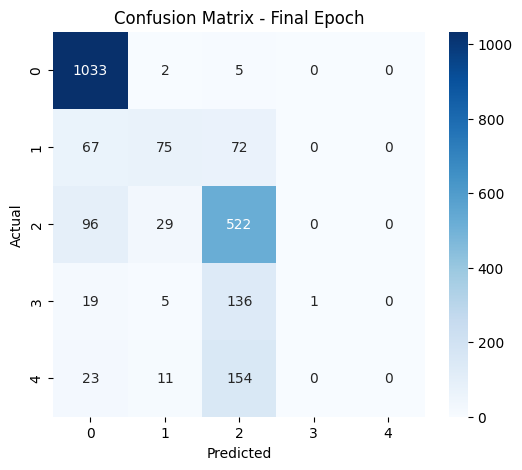

In [8]:
# ---------------- Fast Training Loop (Single Epoch Test) ----------------
import torch.optim as optim
from torch.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = HSDNet(num_classes=5).to(device)
print("Model initialized.")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

scaler = GradScaler(device=device)

EPOCHS = 60                            # ===========================> EPOCH COUNTER
best_acc = 0
patience = 5
counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []
f1_scores = []
lr_history = []

for epoch in range(EPOCHS):
    start_time = time.time()
    print(f"\n🔹 Starting Epoch {epoch+1}/{EPOCHS}")
    
    # --- Training ---
    model.train()
    train_loss, correct, total = 0, 0, 0
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with autocast(device_type='cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if i % 20 == 0:  # print less frequently
            print(f"[Train] Batch {i+1}/{len(train_loader)} | Loss: {loss.item():.4f}")
    
    train_loss /= total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # --- Validation ---
    model.eval()
    val_loss, correct, total = 0, 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    val_loss /= total
    val_acc = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    f1_scores.append(f1)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    lr_history.append(optimizer.param_groups[0]['lr'])
    
    scheduler.step(val_loss)
    
    # --- Checkpoint & Early Stopping ---
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/hsdnet_best.pth")
        print("💾 Model checkpoint saved!")
    else:
        counter += 1
        if counter >= patience:
            print("⏹ Early stopping triggered")
            break
    
    end_time = time.time()
    print(f"✅ Epoch {epoch+1} Summary | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, F1: {f1:.4f} | "
          f"Time: {(end_time - start_time)/60:.2f} mins")

# --- Confusion Matrix after training ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Final Epoch")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


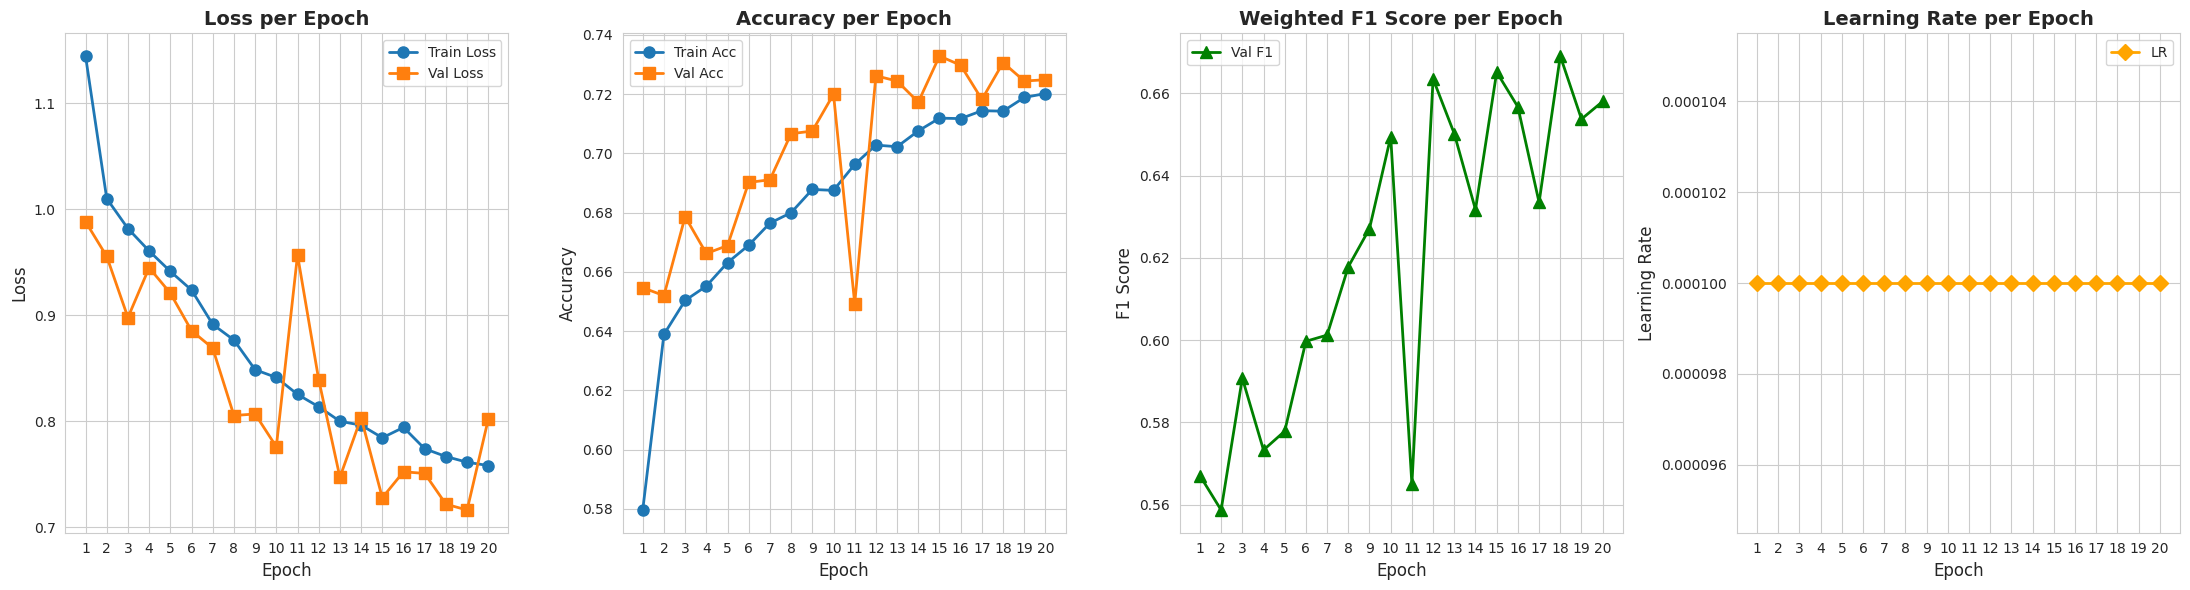

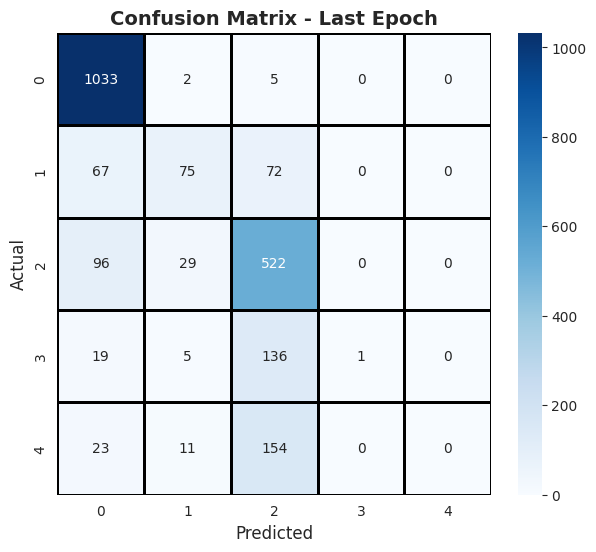

In [9]:
# ---------------- Cell 7: Enhanced Plotting of All Metrics ---------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Epochs range
epochs_range = range(1, len(train_losses)+1)

# ----------- Loss, Accuracy, F1 Score, LR -----------
plt.figure(figsize=(22,6))
sns.set_style("whitegrid")

# 1️⃣ Loss
plt.subplot(1,4,1)
plt.plot(epochs_range, train_losses, marker='o', linewidth=2, markersize=8, label="Train Loss")
plt.plot(epochs_range, val_losses, marker='s', linewidth=2, markersize=8, label="Val Loss")
plt.title("Loss per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(epochs_range)
plt.grid(True)
plt.legend(fontsize=10)

# 2️⃣ Accuracy
plt.subplot(1,4,2)
plt.plot(epochs_range, train_accs, marker='o', linewidth=2, markersize=8, label="Train Acc")
plt.plot(epochs_range, val_accs, marker='s', linewidth=2, markersize=8, label="Val Acc")
plt.title("Accuracy per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(epochs_range)
plt.grid(True)
plt.legend(fontsize=10)

# 3️⃣ Weighted F1 Score
plt.subplot(1,4,3)
plt.plot(epochs_range, f1_scores, marker='^', linewidth=2, markersize=8, color='green', label="Val F1")
plt.title("Weighted F1 Score per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.xticks(epochs_range)
plt.grid(True)
plt.legend(fontsize=10)

# 4️⃣ Learning Rate
plt.subplot(1,4,4)
plt.plot(epochs_range, lr_history, marker='D', linewidth=2, markersize=8, color='orange', label="LR")
plt.title("Learning Rate per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Learning Rate", fontsize=12)
plt.xticks(epochs_range)
plt.grid(True)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

# ----------- Confusion Matrix -----------
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
plt.title("Confusion Matrix - Last Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()


Using device: cuda

Classification Report:

              precision    recall  f1-score   support

           0     0.9201    0.9635    0.9413      1040
           1     0.6533    0.2290    0.3391       214
           2     0.5516    0.9258    0.6913       647
           3     0.0000    0.0000    0.0000       161
           4     0.0000    0.0000    0.0000       188

    accuracy                         0.7333      2250
   macro avg     0.4250    0.4236    0.3943      2250
weighted avg     0.6460    0.7333    0.6661      2250

Weighted F1 Score: 0.6661


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


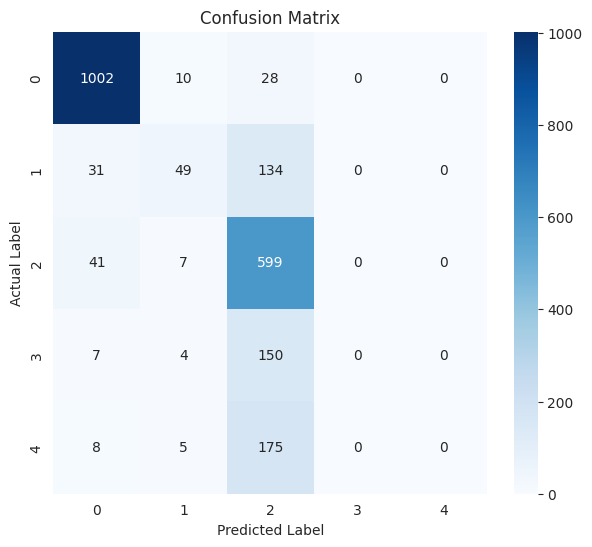

Class 0 Accuracy: 0.9635
Class 1 Accuracy: 0.2290
Class 2 Accuracy: 0.9258
Class 3 Accuracy: 0.0000
Class 4 Accuracy: 0.0000
Total Misclassified Images: 600


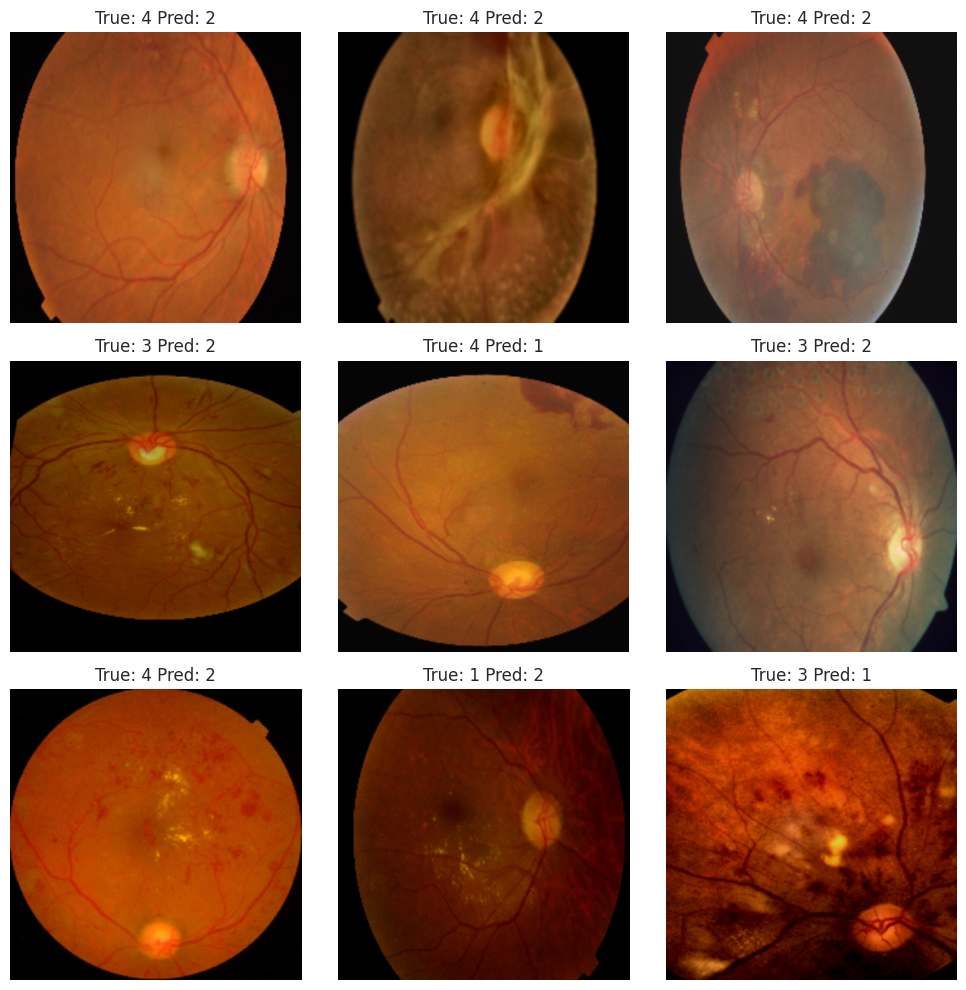

In [10]:
# Cell 8: Model Evaluation on Validation Set as Test ------------------------
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------- Use val_loader as test_loader ----------------
test_loader = val_loader

# ---------------- Device ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------- Load Best Model ----------------
model.load_state_dict(torch.load("/kaggle/working/hsdnet_best.pth"))
model.to(device)
model.eval()

all_labels, all_preds = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(imgs)
            _, predicted = outputs.max(1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# ---------------- Metrics ----------------
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, digits=4))

f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(df.label),
            yticklabels=np.unique(df.label))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# ---------------- Per-class Accuracy ----------------
class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_acc):
    print(f"Class {i} Accuracy: {acc:.4f}")


# ---------------- Misclassified Images ----------------
misclassified = [(img, t, p) for (img, t), p in zip(test_loader.dataset, all_preds) if t != p]
print(f"Total Misclassified Images: {len(misclassified)}")

# Plot first 9 misclassified images
plt.figure(figsize=(10,10))
for i, (img, true, pred) in enumerate(misclassified[:9]):
    img_np = img.permute(1,2,0).numpy()  # convert from C,H,W to H,W,C
    img_np = (img_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # unnormalize
    img_np = np.clip(img_np, 0, 1)
    plt.subplot(3,3,i+1)
    plt.imshow(img_np)
    plt.title(f"True: {true} Pred: {pred}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Manual Model Prediction

In [11]:
# ---------------- Inference on a Single Image ----------------
import torch
import cv2
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2

# ---------------- Settings ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/kaggle/working/hsdnet_best.pth"  # path to your saved model
num_classes = 5
class_names = ["No_DR", "Mild", "Moderate", "Severe", "Proliferative"]  # replace with your labels

# ---------------- Load Model ----------------
model = HSDNet(num_classes=num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ---------------- Image Preprocessing ----------------
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = Compose([
        Resize(512, 512),  # same as training
        Normalize(mean=(0.485, 0.456, 0.406),
                  std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    img_tensor = transform(image=img)['image'].unsqueeze(0)  # add batch dim
    return img_tensor.to(device)

# ---------------- Inference Function ----------------
def predict_image(img_path):
    img_tensor = preprocess_image(img_path)
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        predicted_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0, predicted_idx].item()
    print(f"Image: {img_path}")
    print(f"Predicted Class: {class_names[predicted_idx]} ({predicted_idx}), Confidence: {confidence:.4f}")

# ---------------- Example Usage ----------------
test_image_path = "/kaggle/input/diabetic-retinopathyaugemented-image15k-images/kaggle/input/project-phase-1/DR_augmented/aug_00002_label0.png"
predict_image(test_image_path)


Image: /kaggle/input/diabetic-retinopathyaugemented-image15k-images/kaggle/input/project-phase-1/DR_augmented/aug_00002_label0.png
Predicted Class: No_DR (0), Confidence: 0.9950
